# Loading NYU Data

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset

import torchvision.datasets as dset
import torchvision.transforms as T
import numpy as np

import timeit
import h5py

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
class DepthDataset(Dataset):
    def __init__(self, data_dir):
        self.data_files=[]
        folders=os.listdir(data_dir+'/RGB')
        for folder in folders:
            subfolders=os.listdir(data_dir+'/RGB/'+folder)
            for subfolder in subfolders:
                if subfolder.startswith('.'):
                    continue
                files=os.listdir(data_dir+'/RGB/'+folder+'/'+subfolder)
                for file in files:
                    if not os.path.isfile(data_dir+'/DEP/'+folder+'/'+subfolder+'/'+file):
                        continue
                    if file.endswith('.mat'):
                        self.data_files.append(folder+'/'+ subfolder+'/'+file)
            self.data_dir=data_dir
#         sort(self.data_files)      

    def __getitem__(self, index):
        name=self.data_files[index]
        img=torch.from_numpy(h5py.File(self.data_dir+'/RGB/'+name,'r')['rgbOut'].value).float()
        depth=torch.from_numpy(h5py.File(self.data_dir+'/DEP/'+name,'r')['depthOut'].value).float()
        return img,depth

    def __len__(self):
        return len(self.data_files)

In [3]:
dataset=DepthDataset('../SmallBiggerData')
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start = 0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter((torch.randperm(self.num_samples)+self.start).long())

    def __len__(self):
        return self.num_samples

In [4]:
N=dataset.__len__()
NUM_TRAIN = int(N*0.9)
NUM_VAL = N-NUM_TRAIN
print("NUM_TRAIN:",NUM_TRAIN,",NUM_VAL:",NUM_VAL)
batch_size=8
loader_train = DataLoader(dataset, batch_size=batch_size, sampler=ChunkSampler(NUM_TRAIN, 0),num_workers=8)
loader_val = DataLoader(dataset, batch_size=batch_size, sampler=ChunkSampler(NUM_VAL, NUM_TRAIN),num_workers=8)

NUM_TRAIN: 417 ,NUM_VAL: 47


In [5]:
# image size = [304, 228]
# depth size = [160,128]
print(len(loader_train))

53


# Loading Parameters

## Numpy File

In [6]:
pretrain = np.load('NYU_ResNet-UpProj.npy',encoding='latin1')
print(pretrain.item().keys())

dict_keys(['layer2x_br2_ConvA', 'bn3d_branch2a', 'res3a_branch2b', 'res4f_branch2b', 'res2a_branch2a', 'bn3a_branch2b', 'bn4b_branch2a', 'layer8x_br2_ConvA', 'bn4b_branch2b', 'bn3b_branch2b', 'layer4x_br1_ConvB', 'bn4a_branch2c', 'res4d_branch2a', 'res2a_branch1', 'res2c_branch2a', 'layer8x_br2_ConvC', 'res4c_branch2c', 'layer4x_br2_ConvB', 'layer8x_br2_ConvD', 'bn3d_branch2c', 'layer8x_br1_ConvC', 'res4a_branch1', 'bn3c_branch2c', 'bn2c_branch2b', 'bn5b_branch2c', 'res5b_branch2c', 'layer2x_Conv', 'bn5b_branch2a', 'res4d_branch2c', 'bn4f_branch2a', 'bn4e_branch2c', 'res4b_branch2b', 'res5a_branch1', 'layer4x_br1_ConvC', 'bn4b_branch2c', 'bn3b_branch2a', 'res5b_branch2b', 'bn2a_branch2c', 'bn4c_branch2c', 'res4b_branch2a', 'bn3a_branch2a', 'layer16x_br2_ConvD', 'layer16x_Conv', 'layer8x_br1_ConvB', 'bn4a_branch2b', 'res4a_branch2b', 'bn3a_branch2c', 'res5a_branch2a', 'res5a_branch2b', 'res3b_branch2c', 'bn2a_branch1', 'layer4x_br2_ConvC', 'layer2x_br1_ConvC', 'res4c_branch2a', 'bn2b_br

In [7]:
pretrain.item()['layer4x_br2_ConvB']['weights'].shape

(2, 3, 512, 256)

In [8]:
pretrain.item()['layer1_BN']

{'mean': array([-0.00029113,  0.00106764, -0.00150392, ..., -0.00021943,
        -0.0002065 ,  0.0047509 ], dtype=float32),
 'offset': array([-0.00078779,  0.00016511,  0.00168939, ..., -0.00271009,
         0.00010633, -0.0049724 ], dtype=float32),
 'scale': array([ 0.07726511,  0.07062423,  0.05010203, ...,  0.06819688,
         0.07665947,  0.03478926], dtype=float32),
 'variance': array([  1.37350071e-05,   1.22114288e-05,   2.31600643e-05, ...,
          1.32349305e-05,   1.13116766e-05,   4.54611363e-05], dtype=float32)}

## Mat File

In [ ]:
import scipy.io

In [ ]:
mat = scipy.io.loadmat('NYU_ResNet-UpProj.mat')

In [ ]:
mat.keys()

In [ ]:
mat['params'][0][0][1].shape

In [ ]:
conv1_filter = mat['params'][0][0][1].transpose([3,2,0,1])

In [ ]:
conv1_filter.shape

In [ ]:
mat['params'][0][1][1].shape

In [ ]:
conv1_bias = mat['params'][0][1][1]

# Build Model

In [9]:
import torchvision.models as models

In [10]:
dtype = torch.cuda.FloatTensor

In [11]:
model = models.resnet50(pretrained=True)

In [12]:
mod = list(model.children())

In [13]:
mod

[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False),
 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True),
 ReLU (inplace),
 MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1)),
 Sequential (
   (0): Bottleneck (
     (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
     (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
     (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
     (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
     (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
     (relu): ReLU (inplace)
     (downsample): Sequential (
       (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
       (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True)
     )
   )
   (1): Bottleneck (
     (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1,

In [14]:
mod.pop()

Linear (2048 -> 1000)

In [15]:
mod.pop()

AvgPool2d (
)

In [16]:
resnet50 = torch.nn.Sequential(*mod)

In [17]:
del model

In [18]:
class fastUpProjection(nn.Module):
    def __init__(self,Cin):
        super(fastUpProjection, self).__init__()
        Cout = int(Cin/2)
        self.Cout = Cout
        self.br1convA = nn.Conv2d(Cin,Cout,(3,3),stride=1, padding=1,bias=True)
        self.br1convB = nn.Conv2d(Cin,Cout,(2,3),stride=1, padding=1,bias=True)
        self.br1convC = nn.Conv2d(Cin,Cout,(3,2),stride=1, padding=1,bias=True)
        self.br1convD = nn.Conv2d(Cin,Cout,(2,2),stride=1, padding=1,bias=True)
        self.br1bn = nn.BatchNorm2d(Cout)
        self.br1relu = nn.ReLU()
        self.conv = nn.Conv2d(Cout,Cout,(3,3),stride=1, padding=1,bias=True)
        self.bn = nn.BatchNorm2d(Cout)
        self.br2convA = nn.Conv2d(Cin,Cout,(3,3),stride=1, padding=1,bias=True)
        self.br2convB = nn.Conv2d(Cin,Cout,(2,3),stride=1, padding=1,bias=True)
        self.br2convC = nn.Conv2d(Cin,Cout,(3,2),stride=1, padding=1,bias=True)
        self.br2convD = nn.Conv2d(Cin,Cout,(2,2),stride=1, padding=1,bias=True)
        self.br2bn = nn.BatchNorm2d(Cout)
        self.relu = nn.ReLU()
    def forward(self, x):
        N,C,H,W = x.size()
        a1 = self.br1convA(x)
        b1 = self.br1convB(x)[:,:,:-1,:]
        c1 = self.br1convC(x)[:,:,:,:-1]
        d1 = self.br1convD(x)[:,:,1:,1:]
        #i1 = Variable(torch.zeros((N,self.Cout,2*H,2*W)).type(dtype))
        i1 = torch.cat((a1,a1),2)
        i1 = torch.cat((i1,i1),3)
        #print(i1.size())
        i1[:,:,0::2,0::2] = a1
        i1[:,:,1::2,0::2] = b1
        i1[:,:,0::2,1::2] = c1
        i1[:,:,1::2,1::2] = d1
        bn1 = self.br1bn(i1)
        r1 = self.br1relu(bn1)
        c = self.conv(r1)
        bn = self.bn(c)
        
        a2 = self.br2convA(x)
        b2 = self.br2convB(x)[:,:,:-1,:]
        c2 = self.br2convC(x)[:,:,:,:-1]
        d2 = self.br2convD(x)[:,:,1:,1:]
        #i2 = Variable(torch.zeros((N,self.Cout,2*H,2*W)).type(dtype))
        i2 = torch.cat((a2,a2),2)
        i2 = torch.cat((i2,i2),3)
        i2[:,:,0::2,0::2] = a2
        i2[:,:,1::2,0::2] = b2
        i2[:,:,0::2,1::2] = c2
        i2[:,:,1::2,1::2] = d2
        bn2 = self.br1bn(i2)
        
        s = bn + bn2
        y = self.relu(s)
        return y

In [19]:
upsample = torch.nn.Sequential(
    nn.Conv2d(2048,1024,1,stride = 1,padding=0),
    nn.BatchNorm2d(1024), #1024*10*8
    fastUpProjection(1024),
    fastUpProjection(512),
    fastUpProjection(256),
    fastUpProjection(128),
    nn.Conv2d(64,1,3,stride = 1,padding=1),
    nn.ReLU(),
    )

In [20]:
resnet50.type(dtype)
upsample.type(dtype)

Sequential (
  (0): Conv2d(2048, 1024, kernel_size=(1, 1), stride=(1, 1))
  (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True)
  (2): fastUpProjection (
    (br1convA): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (br1convB): Conv2d(1024, 512, kernel_size=(2, 3), stride=(1, 1), padding=(1, 1))
    (br1convC): Conv2d(1024, 512, kernel_size=(3, 2), stride=(1, 1), padding=(1, 1))
    (br1convD): Conv2d(1024, 512, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (br1bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (br1relu): ReLU ()
    (conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (br2convA): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (br2convB): Conv2d(1024, 512, kernel_size=(2, 3), stride=(1, 1), padding=(1, 1))
    (br2convC): Conv2d(1024, 512, kernel_size=(3, 2), stride=(1, 1), padding=(1, 1))
    (b

## Filling Parameters

In [21]:
def loadConvParameter(conv,data):
    assert(conv.weight.data.size() == torch.from_numpy(data['weights'].transpose([3,2,0,1])).size())
    conv.weight.data = torch.from_numpy(data['weights'].transpose([3,2,0,1]))
    
    assert(conv.bias.data.size() == torch.from_numpy(data['biases']).size())
    conv.bias.data = torch.from_numpy(data['biases'])

In [22]:
def loadBnParameter(bn,data):
    assert(bn.weight.data.size() == torch.from_numpy(data['scale']).size())
    bn.weight.data = torch.from_numpy(data['scale'])
    
    assert(bn.bias.data.size() == torch.from_numpy(data['offset']).size())
    bn.bias.data = torch.from_numpy(data['offset'])
    
    assert(bn.running_mean.size() == torch.from_numpy(data['mean']).size())
    bn.running_mean = torch.from_numpy(data['mean'])
    
    assert(bn.running_var.size() == torch.from_numpy(data['variance']).size())
    bn.running_var = torch.from_numpy(data['variance'])

In [23]:
loadConvParameter(upsample[0],pretrain.item()['layer1'])

In [24]:
loadBnParameter(upsample[1],pretrain.item()['layer1_BN'])

In [25]:
def loadUpProjectParameter(upproject,data,name):
    loadConvParameter(upproject.br1convA,data[name+'_br1_ConvA'])
    loadConvParameter(upproject.br1convB,data[name+'_br1_ConvB'])
    loadConvParameter(upproject.br1convC,data[name+'_br1_ConvC'])
    loadConvParameter(upproject.br1convD,data[name+'_br1_ConvD'])
    loadBnParameter(upproject.br1bn,data[name+'_br1_BN'])
    loadConvParameter(upproject.conv,data[name+'_Conv'])
    loadBnParameter(upproject.bn,data[name+'_BN'])
    
    loadConvParameter(upproject.br2convA,data[name+'_br2_ConvA'])
    loadConvParameter(upproject.br2convB,data[name+'_br2_ConvB'])
    loadConvParameter(upproject.br2convC,data[name+'_br2_ConvC'])
    loadConvParameter(upproject.br2convD,data[name+'_br2_ConvD'])
    loadBnParameter(upproject.br2bn,data[name+'_br2_BN'])

In [26]:
loadUpProjectParameter(upsample[2],pretrain.item(),'layer2x')

In [27]:
loadUpProjectParameter(upsample[3],pretrain.item(),'layer4x')

In [28]:
loadUpProjectParameter(upsample[4],pretrain.item(),'layer8x')

In [29]:
loadUpProjectParameter(upsample[5],pretrain.item(),'layer16x')

In [30]:
loadConvParameter(upsample[6],pretrain.item()['ConvPred'])

In [31]:
resnet50.type(dtype)
upsample.type(dtype)

Sequential (
  (0): Conv2d(2048, 1024, kernel_size=(1, 1), stride=(1, 1))
  (1): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True)
  (2): fastUpProjection (
    (br1convA): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (br1convB): Conv2d(1024, 512, kernel_size=(2, 3), stride=(1, 1), padding=(1, 1))
    (br1convC): Conv2d(1024, 512, kernel_size=(3, 2), stride=(1, 1), padding=(1, 1))
    (br1convD): Conv2d(1024, 512, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
    (br1bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (br1relu): ReLU ()
    (conv): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True)
    (br2convA): Conv2d(1024, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (br2convB): Conv2d(1024, 512, kernel_size=(2, 3), stride=(1, 1), padding=(1, 1))
    (br2convC): Conv2d(1024, 512, kernel_size=(3, 2), stride=(1, 1), padding=(1, 1))
    (b

## Model Testing

In [ ]:
for t,(x,y) in enumerate(loader_train):
    print(t)

In [ ]:
for t,(x,y) in enumerate(loader_train):
    x_var=Variable(x.type(dtype),requires_grad=False)
    #pred=new_model(x_var)
    x1 = resnet50(x_var)
    print(x1.size())
    pred = upsample(x1)
    print(pred.size())
    break

## Training

In [ ]:
#images_var=Variable(images_pytorch.type(dtype),requires_grad=False)
#depths_var=Variable(depths_pytorch.type(dtype),requires_grad=False)

def loss_log(pred,y):
    ep = 1e-6
    N,W,H = 0,0,0
    pred = pred.squeeze()
    if len(pred.size()) == 3:
        N,W,H = pred.size()
    else:
        N = 1
        W,H = pred.size()
    pred = pred.contiguous().view(N,-1)
    y = y.view(N,-1)
    y = y+ep
    d = pred.log() - y.log()
    d[y <= 0] = 0
    n = W*H
    loss = (d.pow(2).sum(1) / n - 0.5 / n/n * d.sum(1).pow(2)).sum()
    loss /= N
    return loss

In [32]:
def berHu(pred,y):
    N,W,H = 0,0,0
    pred = pred.squeeze()
    if len(pred.size()) == 3:
        N,W,H = pred.size()
    else:
        N = 1
        W,H = pred.size()
    pred = pred.contiguous().view(N,-1)
    y = y.view(N,-1)
    x = torch.abs(pred-y)
    
    c,_ = torch.max(x,1)
    c = c/5.0
    c = c.repeat(1,W*H)
    l2 = (x.pow(2) + c.pow(2)) / (2*c)
    lossN = torch.min(x,l2)
    loss = lossN.sum()/(N*H*W)
    return loss

In [ ]:
def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """

    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)

    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

In [33]:
for param in resnet50.parameters():
    param.requires_grad = False

In [ ]:
lr=1e-7
reg=1e-4
adam_optim2=optim.Adam(resnet50.parameters(),lr=lr,weight_decay=reg)

In [34]:
lr=1e-5
reg=1e-4
adam_optim=optim.Adam(upsample.parameters(),lr=lr,weight_decay=reg)

t = 50, loss = 0.4176
epoch: 0 average training loss: 0.63 validation loss: 0.40
t = 50, loss = 0.3322
epoch: 1 average training loss: 0.37 validation loss: 0.34
t = 50, loss = 0.3124
epoch: 2 average training loss: 0.33 validation loss: 0.33
t = 50, loss = 0.3129
epoch: 3 average training loss: 0.31 validation loss: 0.31
t = 50, loss = 0.3008
epoch: 4 average training loss: 0.31 validation loss: 0.31
t = 50, loss = 0.3033
epoch: 5 average training loss: 0.30 validation loss: 0.30
t = 50, loss = 0.2995
epoch: 6 average training loss: 0.29 validation loss: 0.30
t = 50, loss = 0.2970
epoch: 7 average training loss: 0.29 validation loss: 0.30
t = 50, loss = 0.2749
epoch: 8 average training loss: 0.29 validation loss: 0.29
t = 50, loss = 0.2848
epoch: 9 average training loss: 0.28 validation loss: 0.29
t = 50, loss = 0.2709
epoch: 10 average training loss: 0.28 validation loss: 0.28
t = 50, loss = 0.2816
epoch: 11 average training loss: 0.28 validation loss: 0.28
t = 50, loss = 0.2715
epoc

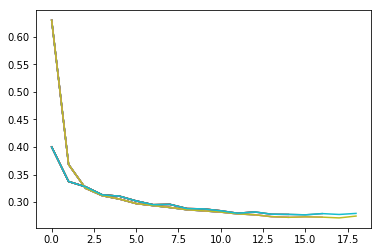

In [35]:
import pickle
print_every=50

def train(model, loss_fn, optimizer, num_epochs = 1, plot_every = 2):
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        model.train() # set the model to training mode, only effect batchnorm and dropout
        avg_train_loss=0
        num_batches=0
        for t,(x,y) in enumerate(loader_train):
            x_var=Variable(x.type(dtype),requires_grad=False)
            y_var=Variable(y.type(dtype),requires_grad=False)
            x1 = resnet50(x_var)
            pred = model(x1)
            loss = loss_fn(pred, y_var)
            #losses.append(loss.data.cpu().numpy())
            
            if (t+1) % print_every==0:
                print('t = %d, loss = %.4f' % (t+1, loss.data[0]))
            avg_train_loss+=loss.data[0]
            num_batches+=1
            optimizer.zero_grad()
            #adam_optim2.zero_grad()
            loss.backward()
            optimizer.step()
            #adam_optim2.step()
            del x,y
        avg_train_loss/=num_batches
        train_losses.append(avg_train_loss)
        
        num_batches=0
        avg_val_loss=0
        for t,(x,y) in enumerate(loader_val):
            x_var=Variable(x.type(dtype),requires_grad=False)
            y_var=Variable(y.type(dtype),requires_grad=False)
            x1 = resnet50(x_var)
            pred = model(x1)
            loss=loss_fn(pred,y_var)
            avg_val_loss+=loss.data[0]
            num_batches+=1
            del x,y
        avg_val_loss/=num_batches
        val_losses.append(avg_val_loss)
        print("epoch:",epoch,"average training loss: %.2f"%avg_train_loss,"validation loss: %.2f" %avg_val_loss)
        if(epoch % plot_every == 0):
            #with open('losses_ep'+ str(epoch)+ '.pickle', 'wb') as f:  # Python 3: open(..., 'wb')
            #    pickle.dump([train_losses,val_losses], f)
            #torch.save(model.state_dict(), 'alldata_dict_ep'+str(epoch))
            plt.plot(train_losses)
            plt.plot(val_losses)
        
            

train(upsample,berHu,adam_optim,num_epochs = 20)

In [ ]:
train(upsample,loss_log,adam_optim,num_epochs = 100)

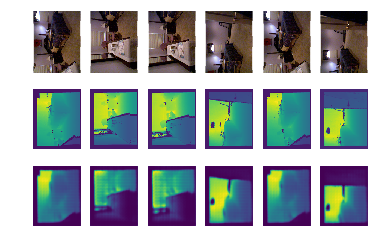

In [36]:
%matplotlib inline

def imshow_noax(img, normalize=True):
    """ Tiny helper to show images as uint8 and remove axis labels """

    if normalize:
        img_max, img_min = np.max(img), np.min(img)
        img = 255.0 * (img - img_min) / (img_max - img_min)

    plt.imshow(img.astype('uint8'))
    plt.gca().axis('off')

# visualize 5 images
NUM_SHOW=6
for t,(x,y) in enumerate(loader_train):
    x_var=Variable(x.type(dtype),requires_grad=False)
    y_var=Variable(y.type(dtype),requires_grad=False)
    upsample.train(False)
    x1 = resnet50(x_var)
    pred = upsample(x1)
    x_var=x_var.cpu()
    y_var=y_var.cpu()
    pred=pred.cpu()
    for i in range(NUM_SHOW):
        plt.subplot(3,NUM_SHOW,i+1)
        img=x_var[i,:,:,:].data.numpy()
        img=np.rollaxis(img,0,3)
        imshow_noax(img,False)
        plt.subplot(3,NUM_SHOW,NUM_SHOW+i+1)
        img=y_var[i,:,:].data.numpy()
        imshow_noax(img)
        plt.subplot(3,NUM_SHOW,2*NUM_SHOW+i+1)
        img=pred[i,0,:,:].data.numpy()
        #img = np.exp(img)
        imshow_noax(img)
    break
plt.show()

In [39]:
def evaluate(loader, model):
    ep = 1e-7

    thresh_1 = 0
    thresh_2 = 0
    abs_diff = 0
    rmse = 0

    for t,(x,y) in enumerate(loader):
        x_var=Variable(x.type(dtype),requires_grad=False)
        y_var=Variable(y.type(dtype),requires_grad=False)
        model.train(False)
        x1 = resnet50(x_var)
        pred = model(x1)
        pred = pred.squeeze()
        #print(y_var.data.cpu().numpy())
        y_var=y_var.data.cpu().numpy()
        y_var = y_var + ep
        pred=pred.data.cpu().numpy() + ep
        num_var = np.shape(y_var)[0]*np.shape(y_var)[1]*np.shape(y_var)[2]

        # threshold
        thresh_mat = np.zeros_like(y_var)
        #print(y_var.shape)
        #print(pred.shape)
        thresh_mat[np.maximum(y_var / pred, pred / y_var) < 1.25] = 1
        thresh_1 += np.sum(thresh_mat)
        thresh_2 += num_var
        #print('t1 = %d, t2 = %d', thresh_1, thresh_2)

        # relative absolute diffe
        abs_diff += np.sum(np.absolute(y_var - pred) / y_var) / num_var

        rmse += np.sqrt(np.sum((y_var - pred) * (y_var - pred)) / num_var)
        


    abs_diff /= len(loader)
    rmse /= len(loader)

    print('percentage within threshold: ', thresh_1 / thresh_2)
    print('relative absolute diff = ', abs_diff)
    print('rmse = ', rmse)

In [40]:
evaluate(loader_val, upsample)

percentage within threshold:  0.729373753324
relative absolute diff =  1432473.70476
rmse =  0.733961158819


## Old

In [ ]:
assert(1==1)